In [13]:
# https://github.com/wshuyi/demo_chinese_text_classification_bert_fastai/blob/master/demo_refactored_dianping_classification_with_BERT_fastai.ipynb
from fastai.text import *

In [33]:
url = 'https://raw.githubusercontent.com/SophonPlus/ChineseNlpCorpus/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv'
df = pd.read_csv(url)

In [46]:
df = df.dropna(subset=['review'])

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train, valid = train_test_split(train, test_size=.2, random_state=2)

In [18]:
!pip install pytorch-transformers

In [48]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
bert_model = "bert-base-chinese"
max_seq_len = 128
batch_size = 32

In [49]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)

In [50]:
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [51]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

In [52]:
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)

In [53]:
path = Path(".")
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="review",
                  label_cols='label',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [54]:
databunch.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
[CLS] 我 是 7 - 10 号 入 住 的 豪 华 海 景 大 床 房 ， 通 过 携 程 预 定 之 前 ， 曾 给 蓝 天 宾 馆 打 过 电 话 ， 当 时 是 告 知 我 没 房 了 ， 我 还 比 较 郁 闷 。 但 是 就 抱 着 试 试 看 的 想 法 ， 在 携 程,1
"[CLS] 不 像 宾 馆 , 像 政 府 招 待 所 . 我 晚 10 点 回 酒 店 就 没 有 餐 饮 供 应 了 , 打 车 很 不 方 便 , 要 步 行 3 - 5 分 钟 才 能 到 临 街 的 马 路 , 设 施 陈 旧 , 结 帐 时 的 清 单 还 要 另 外 到 商",1
[CLS] 这 次 因 工 作 需 要 又 一 次 预 定 这 里 ， 当 我 到 都 江 堰 城 时 感 到 地 震 给 都 江 堰 带 来 的 破 坏 ， 曾 经 繁 华 的 城 市 ， 而 今 [UNK] [UNK] ！ 来 到 二 王 庙 宾 馆 的 时 候 ， 使 我 惊 奇 的 是 这 里,1
[CLS] 同 志 们 . 我 三 四 个 月 住 了 这 酒 店 至 少 十 一 二 次 . 不 图 什 么 . 就 是 安 静 点 . 上 次 他 们 大 堂 经 理 跟 我 说 住 十 次 就 什 么 常 住 客 人 . 优 惠 等 等 . . . 结 果 . . 结 果 . .,1
"[CLS] 哪 里 象 个 4 星 的 样 子 哦 ! 至 少 是 我 住 过 的 4 星 里 面 服 务 最 差 的 . 根 本 就 没 有 服 务 ! 总 台 : 没 有 问 候 , 没 有 笑 容 , 没 有 道 谢 . 象 机 器 人 . 到 处 空 荡 荡 的 . 浴 缸 坏",0


In [55]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [56]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=2)
loss_func = nn.CrossEntropyLoss()
learn = Learner(databunch, 
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


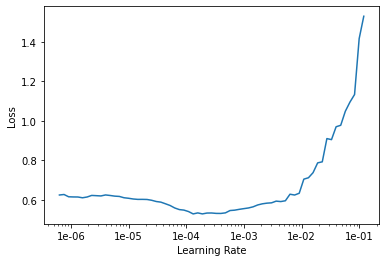

In [57]:
learn.lr_find()
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(2, 2e-5)
def dumb_series_prediction(n):
  preds = []
  for loc in range(n):
    preds.append(int(learn.predict(test.iloc[loc]['review'])[1]))
  return preds
preds = dumb_series_prediction(len(test))

epoch,train_loss,valid_loss,accuracy,time
0,0.187771,0.291438,0.888978,01:46
1,0.114279,0.298750,0.901850,01:39


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(test.label.to_list(), preds)

0.9156471345782357